In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
import keras
from keras.models import Model,Sequential
from keras.optimizers import RMSprop
from tensorflow.math import l2_normalize
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
(xtrain,ytrain),(xtest,ytest)=imdb.load_data(num_words=5000) 

17465344/17464789 [==============================] - 0s 0us/step


In [4]:
word_idx=imdb.get_word_index() #getting vocab from imdb data

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
idx_word=dict([(value,key) for (key,value) in word_idx.items()])
actual_review=[idx_word.get(idx-3,'#') for idx in xtrain[0]] #if key is not present # will be used
actual_review=' '.join(actual_review)
print(actual_review)

# this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for # and would recommend it to everyone to watch and the fly # was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also # to the two little # that played the # of norman and paul they were just brilliant children are often left out of the # list i think because the stars that play them all grown up are such a big # for the whole film but these children are amazing and should be # for what they have done don't you think the whole story was

In [6]:
maxlen=500
xtrain=pad_sequences(xtrain,maxlen=maxlen,padding='post')
xtest=pad_sequences(xtest,maxlen=maxlen,padding='post')

In [7]:
xtrain=np.asarray(xtrain).astype('float32')
xtest=np.asarray(xtest).astype('float32')
ytrain=np.asarray(ytrain).astype('float32')
ytest=np.asarray(ytest).astype('float32')
print(xtrain.shape,xtest.shape)
print(ytrain.shape,ytest.shape)

(25000, 500) (25000, 500)
(25000,) (25000,)


# Model Architecture

In [8]:
input=Input(shape=(maxlen,))
# embedding layer
emb=Embedding(5000,32,trainable=True)(input)
# convLayer1
x=Conv1D(filters=64, kernel_size=5,activation='elu',kernel_regularizer=keras.regularizers.l2(l=0.01))(emb)
x=MaxPooling1D(pool_size=2)(x)
x=BatchNormalization()(x)
# convLayer2
x=Conv1D(filters=128, kernel_size=6,activation='elu',kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
x=MaxPooling1D(pool_size=4)(x)
x=BatchNormalization()(x)
# convLayer3
x=Conv1D(filters=128, kernel_size=7,activation='elu',kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
x=MaxPooling1D(pool_size=8)(x)
x=BatchNormalization()(x)
x=GRU(128)(x)

y=MaxPooling1D(pool_size=2)(emb)
y=GRU(128)(y)

x=concatenate([x,y])

x=Dense(1, activation='sigmoid')(x)
model=Model(inputs=input,outputs=x)
# model.summary()
opt=RMSprop(learning_rate=0.005,decay=0.1)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

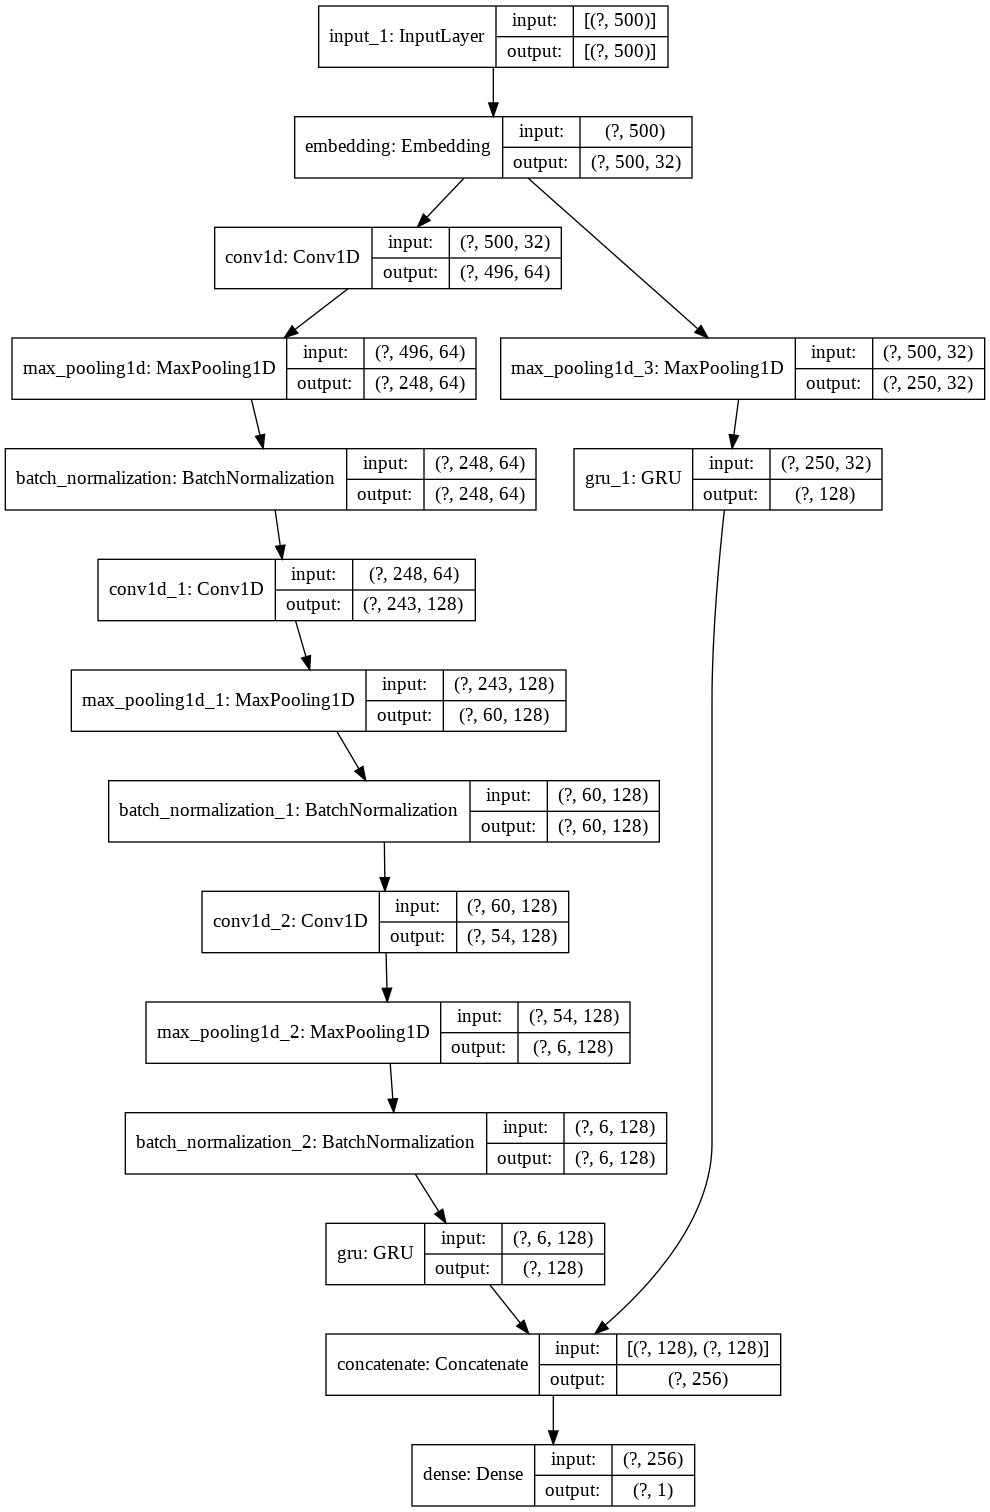

In [10]:
plot_model(model, show_shapes=True, to_file='drive/My Drive/Colab_files/model2.png')

# Training

In [ ]:
hist=model.fit(xtrain,ytrain,batch_size=32,epochs=4,validation_data=(xtest,ytest),validation_batch_size=32)

Epoch 1/4
782/782 [==============================] - 24s 30ms/step - loss: 0.5072 - accuracy: 0.8147 - val_loss: 0.3752 - val_accuracy: 0.8679
Epoch 2/4
782/782 [==============================] - 23s 29ms/step - loss: 0.3125 - accuracy: 0.8938 - val_loss: 0.3344 - val_accuracy: 0.8781
Epoch 3/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2764 - accuracy: 0.9096 - val_loss: 0.3297 - val_accuracy: 0.8827
Epoch 4/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2495 - accuracy: 0.9215 - val_loss: 0.3271 - val_accuracy: 0.8825


In [ ]:
model.save_weights('drive/My Drive/Colab_files/model2.h5')
checkpoint = ModelCheckpoint("model2.hdf5", monitor='accuracy', verbose=0,save_best_only=True,save_weights_only=True,mode='auto')

In [ ]:
opt=RMSprop(learning_rate=0.0005,decay=0.1)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
hist=model.fit(xtrain,ytrain,batch_size=32,epochs=4,validation_data=(xtest,ytest),validation_batch_size=32,callbacks=[checkpoint])

Epoch 1/4
782/782 [==============================] - 23s 30ms/step - loss: 0.2924 - accuracy: 0.9036 - val_loss: 0.3281 - val_accuracy: 0.8837
Epoch 2/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2617 - accuracy: 0.9186 - val_loss: 0.3265 - val_accuracy: 0.8864
Epoch 3/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2524 - accuracy: 0.9204 - val_loss: 0.3269 - val_accuracy: 0.8867
Epoch 4/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2492 - accuracy: 0.9228 - val_loss: 0.3271 - val_accuracy: 0.8867


In [ ]:
model.save_weights('drive/My Drive/Colab_files/model2.h5')

In [ ]:
opt=RMSprop(learning_rate=0.0008,decay=0.1)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
hist=model.fit(xtrain,ytrain,batch_size=32,epochs=4,validation_data=(xtest,ytest),validation_batch_size=32,callbacks=[checkpoint])

Epoch 1/4
782/782 [==============================] - 23s 30ms/step - loss: 0.2982 - accuracy: 0.9034 - val_loss: 0.3277 - val_accuracy: 0.8865
Epoch 2/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2637 - accuracy: 0.9176 - val_loss: 0.3270 - val_accuracy: 0.8878
Epoch 3/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2523 - accuracy: 0.9249 - val_loss: 0.3269 - val_accuracy: 0.8883
Epoch 4/4
782/782 [==============================] - 23s 29ms/step - loss: 0.2456 - accuracy: 0.9253 - val_loss: 0.3257 - val_accuracy: 0.8886


In [ ]:
model.save_weights('drive/My Drive/Colab_files/model2.h5')

In [ ]:
opt=RMSprop(learning_rate=0.0009,decay=0.1)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
hist=model.fit(xtrain,ytrain,batch_size=32,epochs=4,validation_data=(xtest,ytest),validation_batch_size=32,callbacks=[checkpoint])

Epoch 1/4
782/782 [==============================] - 24s 30ms/step - loss: 0.2898 - accuracy: 0.9094 - val_loss: 0.3283 - val_accuracy: 0.8885
Epoch 2/4
782/782 [==============================] - 23s 30ms/step - loss: 0.2558 - accuracy: 0.9220 - val_loss: 0.3254 - val_accuracy: 0.8905
Epoch 3/4
782/782 [==============================] - 23s 30ms/step - loss: 0.2416 - accuracy: 0.9286 - val_loss: 0.3257 - val_accuracy: 0.8913
Epoch 4/4
782/782 [==============================] - 23s 30ms/step - loss: 0.2361 - accuracy: 0.9309 - val_loss: 0.3249 - val_accuracy: 0.8916


# Evaluation

In [9]:
model.load_weights('drive/My Drive/Colab_files/model2.h5')
model.evaluate(xtest,ytest)

782/782 [==============================] - 6s 8ms/step - loss: 0.3214 - accuracy: 0.8920


[0.32137420773506165, 0.8920000195503235]

89.20% Accuracy achieved on test data.